In [17]:
import os
import warnings
import joblib
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
from prophet.serialize import model_to_json
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

In [18]:
def load_dataset(csv_path: str) -> pd.DataFrame:
	df = pd.read_csv(csv_path)
	if "ds" not in df.columns or "y" not in df.columns:
		raise ValueError("Input CSV must contain 'ds' and 'y' columns")
	df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
	df = df.sort_values("ds").reset_index(drop=True)
	df = df.dropna(subset=["ds", "y"])  # ensure target/date exist
	# Fill all remaining NaN values with 0
	df = df.fillna(0)
	return df

In [19]:
def time_series_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
	n = len(df)
	split_idx = int(n * (1 - test_size))
	train_df = df.iloc[:split_idx].copy()
	test_df = df.iloc[split_idx:].copy()
	return train_df, test_df

In [20]:
def build_feature_transformer(df: pd.DataFrame, feature_cols: List[str]) -> ColumnTransformer:
	# Object or string-like columns are treated as categoricals
	cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
	num_cols = [c for c in feature_cols if c not in cat_cols]

	transformer = ColumnTransformer(
		transformers=[
			("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
			("num", "passthrough", num_cols),
		],
		remainder="drop",
	)
	return transformer

In [21]:
def fit_prophet(train_df: pd.DataFrame, regressor_df: pd.DataFrame, feature_names: List[str]) -> Prophet:
	m = Prophet()
	# Filter out any feature names that conflict with Prophet's reserved columns
	safe_feature_names = [name for name in feature_names if name not in ['ds', 'y', 'cap', 'floor']]
	for name in safe_feature_names:
		m.add_regressor(name)
		pass
	train_for_prophet = pd.DataFrame({
		"ds": train_df["ds"].values,
		"y": train_df["y"].values,
		**{name: regressor_df[name].values for name in safe_feature_names},
	})
	m.fit(train_for_prophet)
	return m

In [22]:
def prophet_predict(m: Prophet, df: pd.DataFrame, regressor_df: pd.DataFrame, feature_names: List[str]) -> pd.DataFrame:
	# Filter out any feature names that conflict with Prophet's reserved columns
	safe_feature_names = [name for name in feature_names if name not in ['ds', 'y', 'cap', 'floor']]
	future = pd.DataFrame({
		"ds": df["ds"].values,
		**{name: regressor_df[name].values for name in safe_feature_names},
	})
	forecast = m.predict(future)
	return forecast

In [23]:
def create_residual_sequences(residuals: np.ndarray, daily_income: np.ndarray, regressors: np.ndarray, seq_len: int = 14) -> Tuple[np.ndarray, np.ndarray]:
	X, y = [], []
	for i in range(seq_len, len(residuals)):
		# Use a window of regressors aligned to time, optionally stack residuals too
		X.append(regressors[i - seq_len:i])  # shape (seq_len, n_features)
		y.append(residuals[i])
	X = np.array(X)
	y = np.array(y)
	return X, y

In [24]:
def build_lstm(input_shape:Tuple[int, int]) -> Sequential:
	model = Sequential([
		LSTM(32, return_sequences=False, input_shape=input_shape),
		Dense(16, activation="relu"),
		Dense(1),
	])
	model.compile(optimizer="adam", loss="mse")
	return model

In [25]:
def train_prophet_lstm(csv_path: str,
						test_size: float = 0.2,
						seq_len: int = 30,
						epochs: int = 100,
						batch_size: int = 32,
						models_dir: str = "models"):
	df = load_dataset(csv_path)
	
	df = df.drop(columns=['Job_Categories', "Job_Duration_Days", "Target_Income_Next_Day", "Month", "Monthly_Income", "Monthly_Expenses", "Target_Income_Next_Month", "Income_Total"], errors='ignore')
	
	# Identify features
	feature_cols = [c for c in df.columns if c not in ["ds", "y"]]
	print(f"Using features: {feature_cols}")
	transformer = build_feature_transformer(df, feature_cols)

	# Fit transformer on train only to avoid leakage
	train_df, test_df = time_series_split(df, test_size=test_size)

	# Build a pipeline solely for transformation (fit on train -> transform train/test)
	feature_pipe = Pipeline(steps=[("transform", transformer)])
	X_train_raw = train_df[feature_cols]
	X_test_raw = test_df[feature_cols]

	X_train = feature_pipe.fit_transform(X_train_raw)
	X_test = feature_pipe.transform(X_test_raw)

	# Clean transformed data - replace NaN/Inf with 0
	X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
	X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

	# Retrieve transformed feature names for Prophet regressors
	cat_cols = transformer.transformers_[0][2] if transformer.transformers_ else []
	num_cols = transformer.transformers_[1][2] if transformer.transformers_ else []
	# For OrdinalEncoder, feature names are just the column names
	feature_names = list(cat_cols) + list(num_cols)

	# Build dataframes for regressors matching Prophet expectations
	reg_train_df = pd.DataFrame(X_train, columns=feature_names, index=train_df.index)
	reg_test_df = pd.DataFrame(X_test, columns=feature_names, index=test_df.index)

	# Train Prophet with regressors on train set
	prophet_model = fit_prophet(train_df, reg_train_df, feature_names)

	# Prophet predictions for train and test
	forecast_train = prophet_predict(prophet_model, train_df, reg_train_df, feature_names)
	forecast_test = prophet_predict(prophet_model, test_df, reg_test_df, feature_names)
	prophet_model.plot_components(forecast_test)

	y_train = train_df["y"].values
	y_test = test_df["y"].values
	yhat_train = forecast_train["yhat"].values
	yhat_test = forecast_test["yhat"].values

	residuals_train = y_train - yhat_train
	residuals_test = y_test - yhat_test

	# Prepare sequences for LSTM using transformed regressors
	X_seq_train, y_seq_train = create_residual_sequences(residuals_train, train_df['y'].values, reg_train_df.values, seq_len=seq_len)
	# For test, to forecast residuals at time t, we also need preceding window; here we build purely within the test set
	X_seq_test, y_seq_test = create_residual_sequences(residuals_test, test_df['y'].values, reg_test_df.values, seq_len=seq_len)

	if len(X_seq_train) == 0 or len(X_seq_test) == 0:
		raise ValueError("Not enough data to build sequences. Consider reducing seq_len or providing more data.")

	# lstm_model = build_lstm((X_seq_train.shape[1], X_seq_train.shape[2]))
	lstm_model = build_lstm((X_seq_train.shape[1], X_seq_train.shape[2]))
	es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
	lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

	# Predict residuals on test sequences
	pred_residuals_test = lstm_model.predict(X_seq_test, verbose=0).reshape(-1)

	# Align final evaluation: prophet yhat for the portion that matches y_seq_test indices
	# y_seq_test starts from index seq_len within test segment
	aligned_yhat_test = yhat_test[seq_len:seq_len + len(pred_residuals_test)]
	aligned_y_test = y_test[seq_len:seq_len + len(pred_residuals_test)]

	final_pred_test = aligned_yhat_test + pred_residuals_test

	mae = mean_absolute_error(aligned_y_test, final_pred_test)
	rmse = np.sqrt(mean_squared_error(aligned_y_test, final_pred_test))

	# Get test dates for aligned predictions
	test_dates = test_df["ds"].values[seq_len:seq_len + len(pred_residuals_test)]

	os.makedirs(models_dir, exist_ok=True)
	# Save models and transformer
	with open('./models/serialized_model.json', 'w') as fout:
		fout.write(model_to_json(prophet_model))  # Save model
	# Save LSTM via Keras
	lstm_model.save(os.path.join(models_dir, "lstm_residual_model.keras"))
	# Save feature pipeline using joblib
	joblib.dump(feature_pipe, os.path.join(models_dir, "feature_pipeline.joblib"))

	return {
		"mae": mae,
		"rmse": rmse,
		"test_predictions": final_pred_test,
		"test_actual": aligned_y_test,
		"prophet_predictions": aligned_yhat_test,
		"test_dates": test_dates,
		"seq_len": seq_len,
	}

In [26]:
def plot_forecasts(results: dict, save_path: str = "models/forecast_plot.png"):
	"""Plot actual vs predicted values for Prophet, LSTM, and combined model."""
	fig, axes = plt.subplots(2, 1, figsize=(14, 10))
	
	dates = results["test_dates"]
	actual = results["test_actual"]
	prophet_pred = results["prophet_predictions"]
	combined_pred = results["test_predictions"]
	
	# Plot 1: Prophet vs Combined Prophet+LSTM
	axes[0].plot(dates, actual, label="Actual", color="black", linewidth=2, marker='o', markersize=4)
	axes[0].plot(dates, prophet_pred, label="Prophet Only", color="blue", linewidth=1.5, linestyle='--', alpha=0.7)
	axes[0].plot(dates, combined_pred, label="Prophet + LSTM", color="red", linewidth=1.5, alpha=0.8)
	axes[0].set_title("Prophet vs Prophet+LSTM Forecast", fontsize=14, fontweight='bold')
	axes[0].set_xlabel("Date", fontsize=12)
	axes[0].set_ylabel("Income Total", fontsize=12)
	axes[0].legend(loc='best', fontsize=10)
	axes[0].grid(True, alpha=0.3)
	axes[0].tick_params(axis='x', rotation=45)
	
	# Plot 2: Residuals comparison
	prophet_residuals = actual - prophet_pred
	combined_residuals = actual - combined_pred
	axes[1].plot(dates, prophet_residuals, label="Prophet Residuals", color="blue", linewidth=1.5, alpha=0.7)
	axes[1].plot(dates, combined_residuals, label="Prophet+LSTM Residuals", color="red", linewidth=1.5, alpha=0.7)
	axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
	axes[1].set_title("Prediction Residuals", fontsize=14, fontweight='bold')
	axes[1].set_xlabel("Date", fontsize=12)
	axes[1].set_ylabel("Residuals", fontsize=12)
	axes[1].legend(loc='best', fontsize=10)
	axes[1].grid(True, alpha=0.3)
	axes[1].tick_params(axis='x', rotation=45)
	
	plt.tight_layout()
	# plt.savefig(save_path, dpi=150, bbox_inches='tight')
	print(f"Forecast plot saved to: {save_path}")
	plt.show()

01:51:44 - cmdstanpy - INFO - Chain [1] start processing
01:51:44 - cmdstanpy - INFO - Chain [1] done processing


Using features: ['Job_Type', 'Hours_Worked', 'Platform_Count', 'Local_Gas_Price', 'Expenses_Total', 'Public_Holiday_Flag', 'Monthly_Unemployment_Rate', 'income_volatility_index', 'income_rolling_avg_3m', 'expense_to_income_ratio', 'net_Income', 'savings']
MAE: 0.01, RMSE: 0.02, seq_len: 30


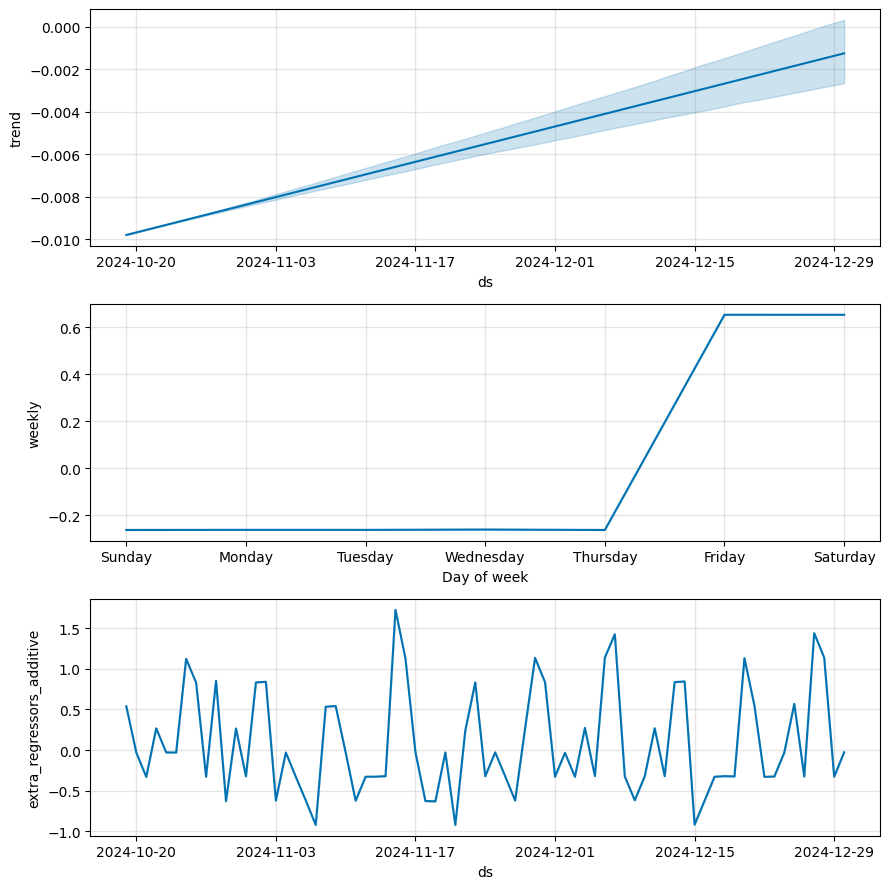

In [27]:
csv_path = "./features_a.csv"
results = train_prophet_lstm(csv_path)
print(f"MAE: {results['mae']:.2f}, RMSE: {results['rmse']:.2f}, seq_len: {results['seq_len']}")

Forecast plot saved to: models/forecast_plot.png


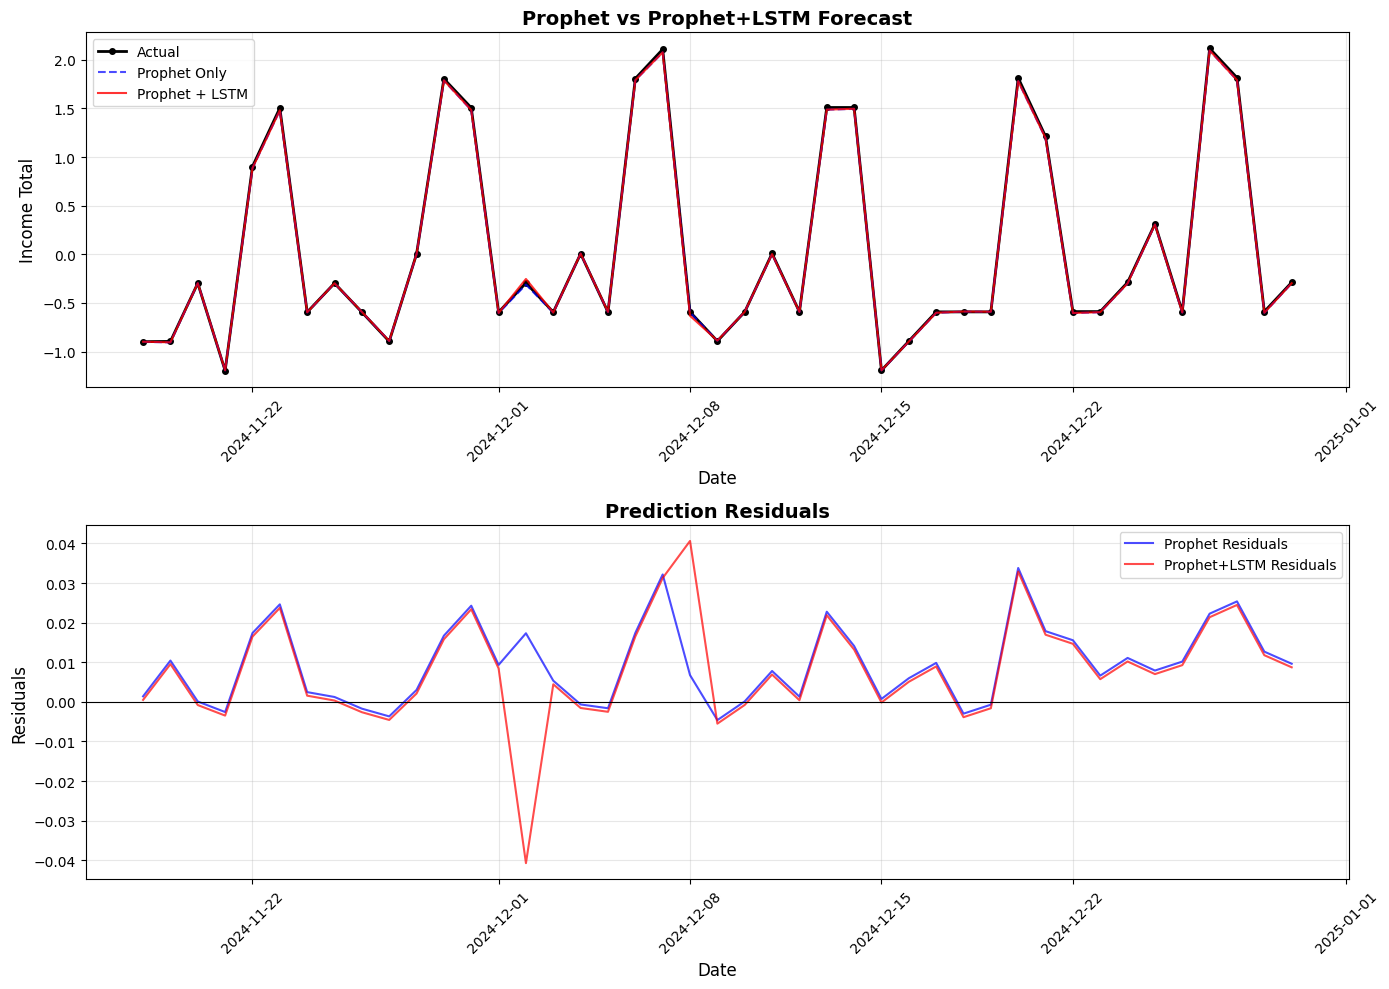

In [15]:
# Plot forecasts
plot_forecasts(results)